In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Importamos el dataset

In [ ]:
from sklearn.datasets import load_diabetes
X, y = load_diabetes(return_X_y=True)

## Dividimos eldataset en train test 

In [ ]:
# Importamos el modelo para separar el dataset
from sklearn.model_selection import train_test_split

# Dividimos el dataset en train (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

## KNN

In [ ]:
# Importamos el modelo desde 'neighbors'
# ===============================================
from sklearn.neighbors import KNeighborsClassifier

# Instanciamos el objeto neigh de la clase KNeighborsClassifer
# ===============================================
neigh = KNeighborsClassifier(n_neighbors=1) # Utilizamos k=1

# Entrenamos el modelo
# ===============================================
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [ ]:
# Métrica
# ==================================================

# Importamos la métrica a utilizar
from sklearn.metrics import mean_squared_error

# calculamos la predición en train test
y_pred_train = neigh.predict(X_train)
y_pred_test  = neigh.predict(X_test)

# calculamos mse en train test
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test  = mean_squared_error(y_test,  y_pred_test)

# Imprimos mse train test
print(f"mse en entrenamiento: {mse_train:.2f}")
print(f"mse en test         : {mse_test:.2f} \n")

mse en entrenamiento: 0.00
mse en test         : 4128.00 



## Cross Validation

In [ ]:
# Importamos el modelo
# ==============================================
from sklearn.model_selection import cross_validate

# utilizamos mse como métrica de evaluación
scoring = 'neg_mean_squared_error'

# preparación del modelo
cv_scores = cross_validate(neigh, X_train, y_train, cv=5, return_train_score=True, return_estimator=True, scoring=scoring)

# tabulamos los datos
pd.DataFrame((cv_scores.values()), index=cv_scores.keys()).T \
        .filter(regex = '(train_score|test_score)') \
        .reindex(columns=['train_score','test_score'])

C:\Users\Rodrigo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


,train_score,test_score
0,-0,-4495.34
1,-0,-5719.2
2,-0,-6275.82
3,-0,-7391.1
4,-0,-5541.29


El modelo está excesivamente sobreajustado porque se ajusta a los datos de forma perfecta el dataset de entrenamiento pero existe una desviación importante en el de prueba.

Tanto mediante la técnica hold out como con cross validation se observa que mse en el entrenamiento es 0, esto es debido a que matemáticamente para k=1 $f(x_0) = y_i$ por lo que el porcentaje de acierto es del 100% pero, esta premisa no es válida para el de validación motivo por el cuál no consigue generalizar.

## CÁLCULO DE HIPERPARÁMETROS

In [ ]:
# Gridsearh búsqueda de hiperparámetros
# ==============================================
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

# Estimador a utilizar
# ==============================================
est = KNeighborsClassifier()

# Rejilla
# ==============================================
grid = {'n_neighbors': np.linspace(1,50,50).astype('int')}

# Métrica: mse
# ==============================================
scoring = 'neg_mean_squared_error'

# Validador
# ==============================================
rkf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=32)

# Definición del modelo
# ==============================================
est2 = GridSearchCV(
        estimator  = est, 
        param_grid = grid, 
        scoring    = scoring,
        n_jobs     = -1, 
        refit      = True, 
        cv         = rkf,
        return_train_score = True
    )

est2.fit(X_train, y_train);

In [ ]:
print (f'{est2.best_params_} \n mse:{est2.best_score_.round(2)}')

{'n_neighbors': 38} 
 mse:-6608.36


### El valor óptimo de K es K=38

In [ ]:
resultados = pd.DataFrame(est2.cv_results_) \
        .filter(regex = '(param.*|mean_t)') \
        .drop('params', axis=1)

### Representación gráfica del modelo

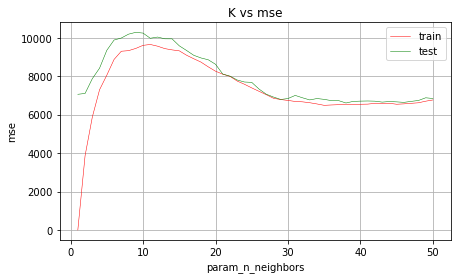

In [ ]:
fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot() 
resultados.groupby('param_n_neighbors')['mean_train_score'].max().abs().plot(ax = ax, color='r', linewidth=0.5, grid=True, label='train')
resultados.groupby('param_n_neighbors')['mean_test_score'].max().abs().plot(ax = ax, color='g', linewidth=0.5, grid=True, label='test')
ax.set_title('K vs mse')
ax.set_ylabel('mse')
#ax.set_xlim([1, 50])
ax.legend();

Se observa como a partir de K=30 el valor de mse tanto para train como test se estabiliza y con valores cercanos a 40 son muy próximos y estables.

In [ ]:
# Métricas

modelo_final = est2.best_estimator_

y_pred_train = modelo_final.predict(X_train)
y_pred_test  = modelo_final.predict(X_test)

accuracy_train = mean_squared_error(y_train,y_pred_train)
accuracy_test  = mean_squared_error(y_test,y_pred_test)

# 'Accuracy'
print(f"mse en entrenamiento: {accuracy_train:.2f}")
print(f"mse en test         : {accuracy_test:.2f} \n")

mse en entrenamiento: 6481.32
mse en test         : 7034.34 



## CROSS VALIDATION

In [ ]:
scoring = 'neg_mean_squared_error'
cv_scores = cross_validate(modelo_final, X_train, y_train, cv=5, return_train_score=True, return_estimator=True, scoring=scoring)

pd.DataFrame((cv_scores.values()), index=cv_scores.keys()).T \
        .filter(regex = '(train_score|test_score)') \
        .reindex(columns=['train_score','test_score']) \
        .abs()

C:\Users\Rodrigo\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


,train_score,test_score
0,7115.16,6371.27
1,7070.45,6619.11
2,7354.37,5057.11
3,5873.69,5202.33
4,6364.5,7399.17


Al volver a aplicar validación cruzada vemos que el error de sobreajuste encontrado en el modelo de K=1 ha disminudio notablemente porque encontramos valores similares entre los datasets train/ test aunque sigue apreciándose un cierto desequilibrio.

# Predicción final

In [ ]:
pd.DataFrame(modelo_final.predict(X_test))

,0
0,59.0
1,53.0
2,83.0
3,97.0
4,59.0
...,...
84,90.0
85,53.0
86,122.0
87,68.0
